<a href="https://colab.research.google.com/github/vidhya2324/Neutral_network/blob/main/human_action_recognition(LSTM%2BCNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**OUTLINE**

Step 1: Download and Visualize the Data with its Labels

step 2: preprocess the Dataset

step 3: Spllit the Data into Train and Test Set

Step 4: Implement the ConvLSTM Approach

    step 4.1: Construct the Model

    step 4.2: Compile & Train the Model

    step 4.3: Plot Model's Loss & Accuracy Curves

Step 5: Implement the LRCN Approach

    Step 5.1: Construct the Model

    step 5.2: Compile & Train the Model

    step 5.3: Plot Model's Loss & Accuracy Curves

Step 6: Test the Best Performing Model on Youtube video


#Import Libraries


In [3]:
# Discard the output of this cell.
%%capture

#Install the required libraries.
!pip install pafy youtube-dl moviepy #access the youtube video and download it and use it here.

In [4]:
#import the required libraries.
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model


In [5]:
#to control the random values
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [6]:
# Discord the output of this cell.
#To save the output of a cell as a text file
%%capture

#Download the UCF50 Dataset
!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar

#Extract the Dataset or unzip
!unrar x UCF50.rar

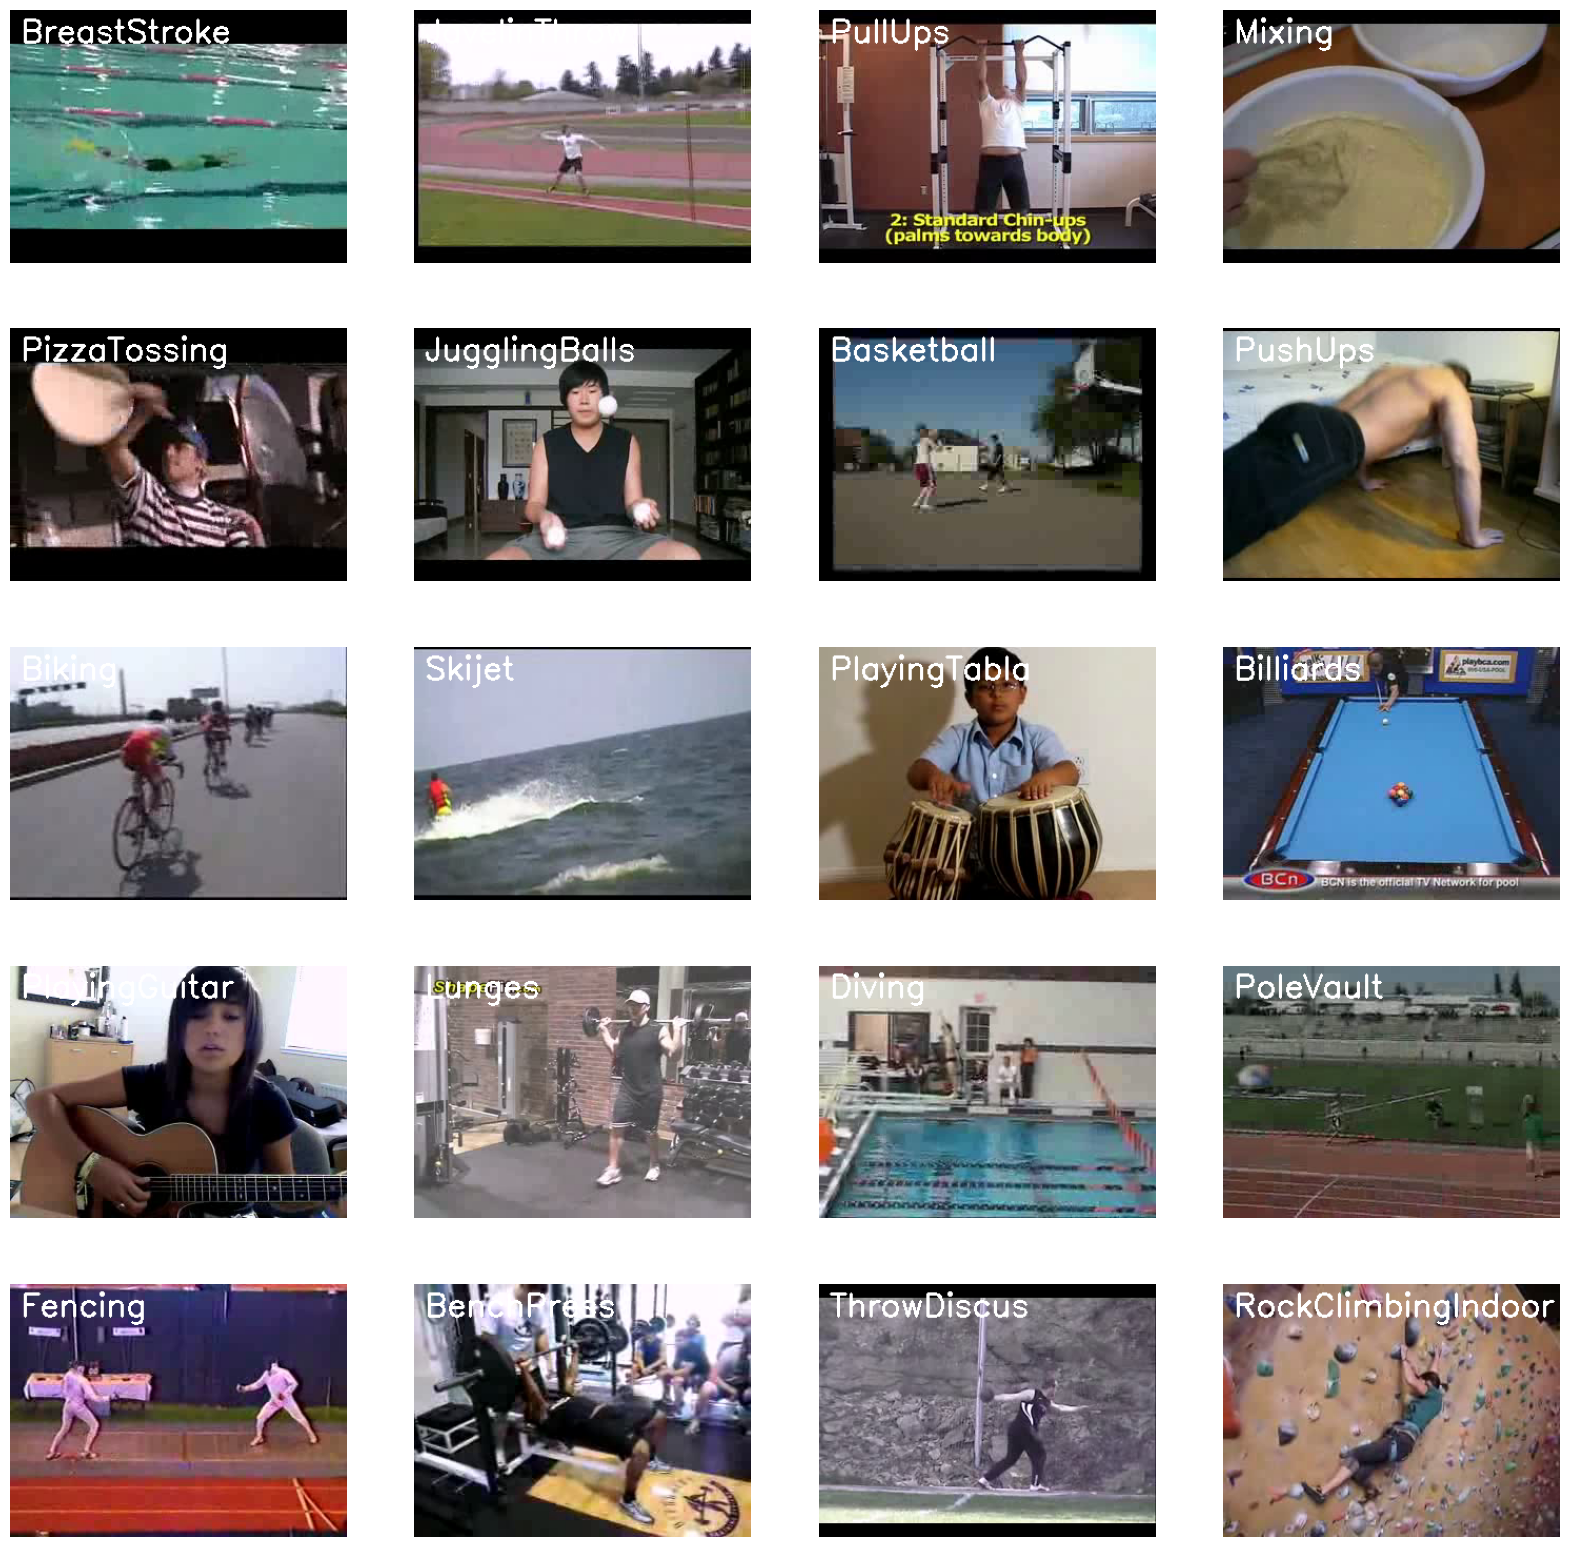

In [7]:
# create a matplotlib figure and specify the size of the figure.
plt.figure(figsize=(20,20))

# get the names of all classes/categories in ucf50.
all_classes_names=os.listdir('UCF50')

# generate a list of 20 random values. the values will be between 0-50,
#where 50 is the total number of clas in the dataset.
random_range=random.sample(range(len(all_classes_names)), 20)

#Iterating through all the generated random values.
for counter, random_index in enumerate(random_range,1):
  #Retrieve a class name using the random index.
  selected_class_Name=all_classes_names[random_index]

  #retrieve a list of all the video files present in the randomly selected class directory.
  video_files_names_list =os.listdir(f'UCF50/{selected_class_Name}')

  #select a random video file from the list of the video files.
  selected_video_file_name=random.choice(video_files_names_list)

  #Initiallize a videocapture object to read from the video file.
  video_reader=cv2.VideoCapture(f'UCF50/{selected_class_Name}/{selected_video_file_name}')

  #read a single frame from the video.
  _,bgr_frame=video_reader.read()

  #release the videocapture object.
  video_reader.release()

  #convert the frame from BGR to RGB format.
  rgb_frame=cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

  #Write the class name on the video frame.
  cv2.putText(rgb_frame, selected_class_Name, (10,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)

  #Display the frame.
  plt.subplot(5,4,counter);plt.imshow(rgb_frame);plt.axis('off')

##Preprocessing the Data

In [8]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT, IMAGE_WIDTH =64,64

#Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH =20

#Specify the directory containing the UCF50 dataset.
DATASET_DIR="UCF50"

#specify the list containing the names of the classes used for training, Feel free to choose any set of classes.
CLASSES_LIST =["WalkingWithDog","TaiChi","Swing","HorseRace"]

#Create a function to extract, resize and normalize frames

In [14]:
def frames_extraction(video_path):
  '''
  This function will extract the required frames from a video after resizing and normalizing them.
  Args:
    video_path: The path of the video in the disk, whose frames are to be extracted.
  Returns:
    frames_list: A list containing the resized and normalized frames of the video.
  '''

  # Empty List declared to store the frames of the video.
  frames_list = []

  # Reading the Video File Using the VideoCapture Object.
  video_reader = cv2.VideoCapture(video_path)

  #Get the total number of frames in the video.
  video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

  #Calculate the the interval after which frames will be added to the list.
  skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH),1)

  #Iterate through the Video Frames.
  for frame_counter in range(SEQUENCE_LENGTH):

    #Set the current frame position of the video.
    video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

    #Reading the frame from the video.
    success, frame = video_reader.read()

    #Check if Video frame is not successfully read then break the loop
    if not success:
      break

    # Resize the Frame to fixed height and width.
    resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

    #Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
    normalized_frame = resized_frame / 255

    #Append the normalized frame into the frames list
    frames_list.append(normalized_frame)

  #Release the VideoCapture object.
  video_reader.release()

  #Return the frames list.
  return frames_list

# Create a function for Dataset Creation

now we will create a function create_dataset() that will iterate through all the classes specified in the classes_list constant and will call the function frame_extraction() on every video file of the selected classes and return the frames(features), class index(labels), and video file path(video_files_paths).

In [18]:
def create_dataset():
  '''
  This function will extract the data of the selected classes and create the required dataset.
  Returns:
    features:          A list containing the extracted frames of the videos.
    labels:            A list containing the indexes of the classes associated with the videos.
    video_files_paths: A list containing the paths of the videos in the disk.
  '''

  # Declared Empty Lists to store the features, labels and video file path values.
  features = []
  labels = []
  video_files_paths = []

  # Iterating through all the classes mentioned in the classes list
  for class_index, class_name in enumerate(CLASSES_LIST):

    #Display the name of the class whose data is being extracted.
    print(f'Extracting Data of Class: {class_name}')

    # Getting the list of video files present in the specific class index directory.
    files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

    #Iterate through all the files present in the files list.
    for file_name in files_list:

      #Get the complete video path.
      video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

      #Extract the frames of the video file.
      frames = frames_extraction(video_file_path)

      #check if the extracted frames are equal to the sequence_length specified above.
      #So ignore the videos having frames less than the SEQUENCE_LENGTH.
      if len(frames) == SEQUENCE_LENGTH:

        #Append the data to their repective lists.
        features.append(frames)
        labels.append(class_index)
        video_files_paths.append(video_file_path)

  #Converting the list to numpy arrays
  features = np.asarray(features)
  labels = np.array(labels)

  #Return the frame, class index, and video file path.
  return features, labels, video_files_paths

In [19]:
#create the dataset.
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: WalkingWithDog
Extracting Data of Class: TaiChi
Extracting Data of Class: Swing
Extracting Data of Class: HorseRace


In [20]:
#using keras's to_categorical method to convert labels into one-hot encoded vectors
one_hot_encoded_labels = to_categorical(labels)

#Split the data into train and test set

In [21]:
#Split the data into train(75%) and test set(25%).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.25, shuffle = True, random_state = seed_constant)

#Implement the ConvLSTM approach

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, MaxPooling3D, TimeDistributed, Dropout, Flatten, Dense


def create_convlstm_model():
  '''
  This function will build the convolutional LSTM model.
  Returns:
    model: It is the required convolutional lstm model.
  '''
  model = Sequential()

  #Define the Model Architecture
  #########################################################################################################################

  model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                        recurrent_dropout=0.2, return_sequences=True, input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

  model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))

  model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                        recurrent_dropout=0.2, return_sequences=True))

  model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))

  model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                        recurrent_dropout=0.2, return_sequences=True))

  model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))

  model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                        recurrent_dropout=0.2, return_sequences=True))


  model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))

  model.add(Flatten())

  model.add(Dense(len(CLASSES_LIST), activation = "softmax"))

  #########################################################################################################################

  #Display the models summary.
  model.summary()

  return model
  #End


Now We will utilize the function create_convlstm_odel() created above, to construct the required convlstm model.

In [26]:
#Construct the required convlstm model.
convlstm_model = create_convlstm_model()


#Display the success message.
print("Model Created Successfully!")

  super().__init__(**kwargs)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, 20, 62, 62, 4)  │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 20, 31, 31, 4)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 20, 31, 31, 4)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 20, 29, 29, 8)  │         3,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 20, 15, 15, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 20, 15, 15, 8)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_2 (ConvLSTM2D)      │ (None, 20, 13, 13, 14) │        11,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 20, 7, 7, 14)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 20, 7, 7, 14)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_3 (ConvLSTM2D)      │ (None, 20, 5, 5, 16)   │        17,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 20, 3, 3, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2880)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │        11,524 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,524 (173.92 KB)

 Trainable params: 44,524 (173.92 KB)

 Non-trainable params: 0 (0.00 B)

Model Created Successfully!


#Check Model's Structure:

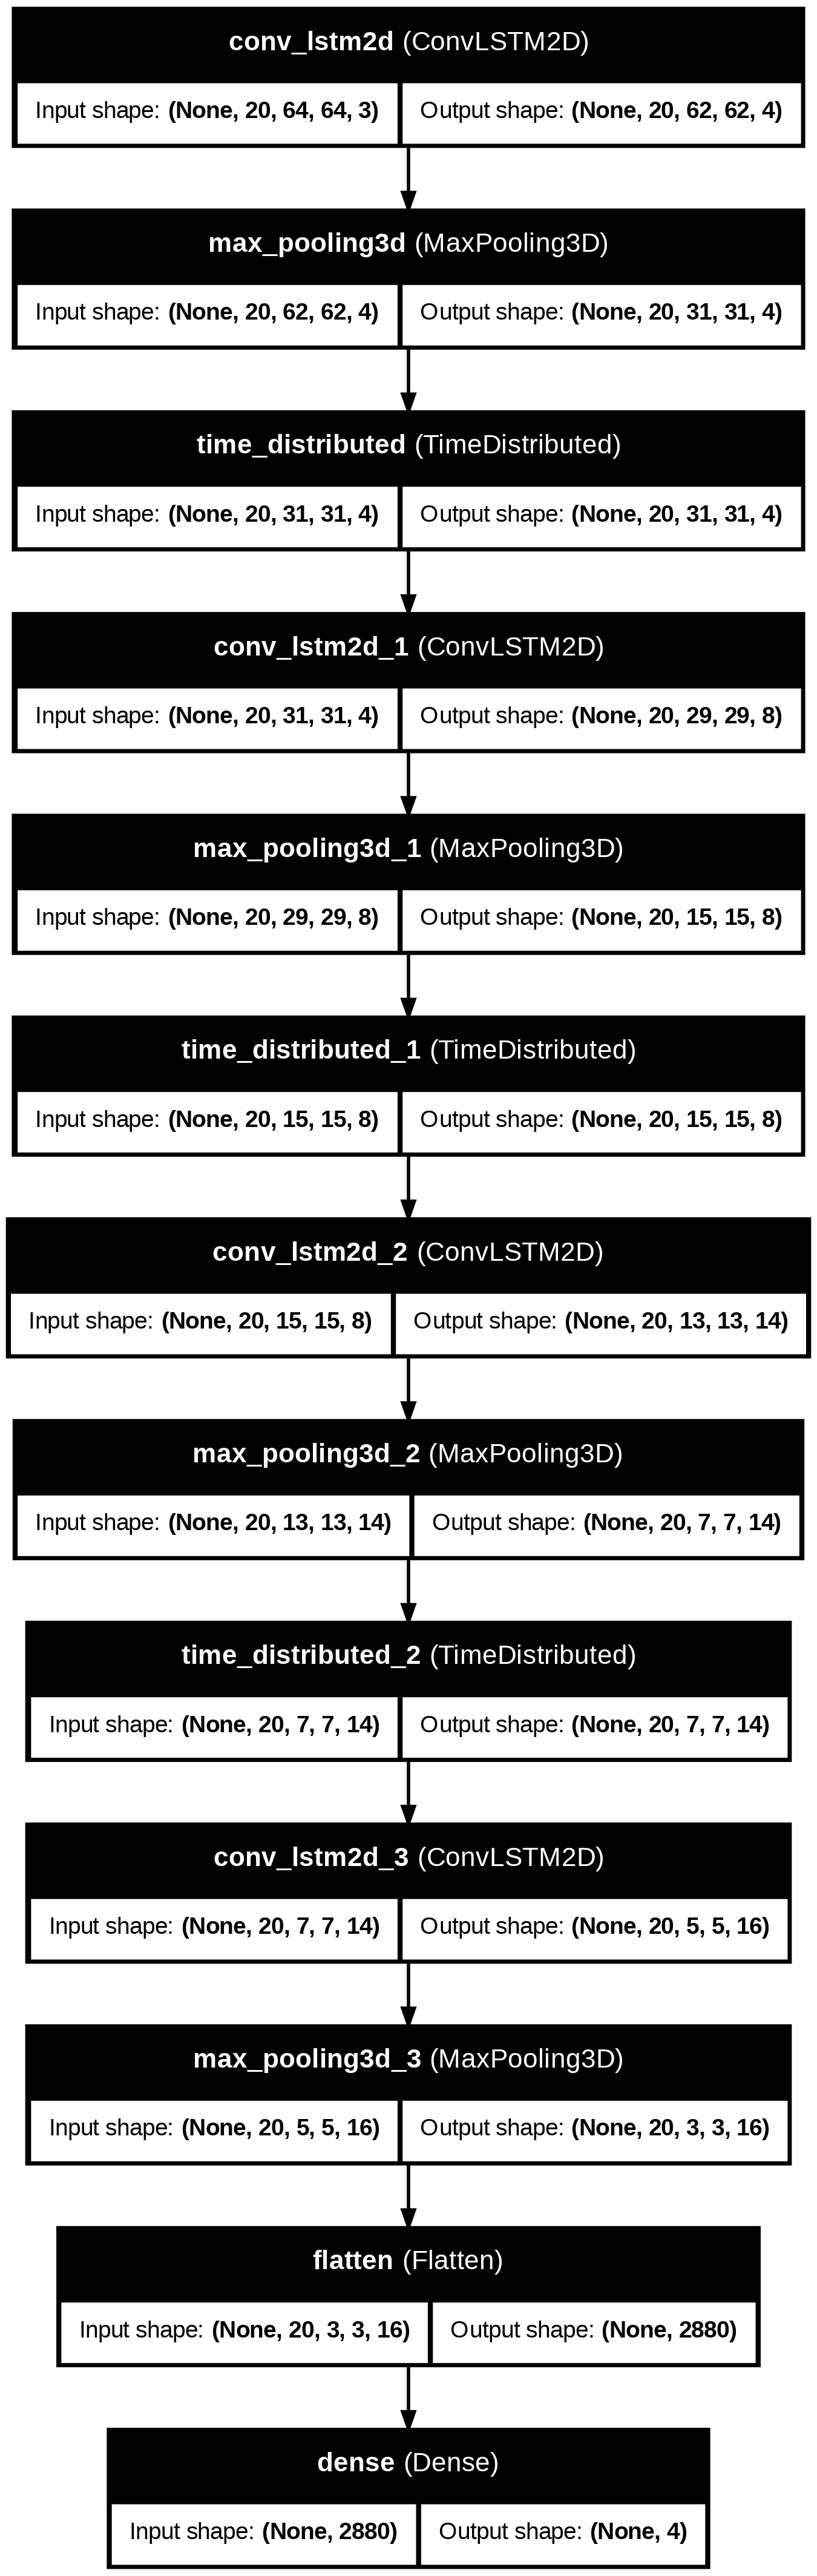

In [27]:
#Plot the structure of the contructed model.
plot_model(convlstm_model, to_file = 'convlstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)

#Compile & Train the Model

In [29]:
# Create an Instace of Early Stopping calback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)


# compile the model and specify loss function, optimizer and metrics values to the model
convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

#start training the model.
convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train, epochs =50, batch_size = 4, shuffle = True, validation_split= 0.2,
                                                     callbacks = [early_stopping_callback])

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.4709 - loss: 1.2913 - val_accuracy: 0.5616 - val_loss: 1.0109
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.4936 - loss: 1.2402 - val_accuracy: 0.6438 - val_loss: 0.9723
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 151s 2s/step - accuracy: 0.5355 - loss: 1.1358 - val_accuracy: 0.6164 - val_loss: 0.8370
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.6051 - loss: 1.0301 - val_accuracy: 0.6301 - val_loss: 0.7741
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.6360 - loss: 0.8778 - val_accuracy: 0.6986 - val_loss: 0.7170
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.6159 - loss: 0.9111 - val_accuracy: 0.6712 - val_loss: 0.6866
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - accuracy: 0.7437 - loss: 0.6607 - val_accuracy: 0.7671 - val_loss: 0.6786
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.7963 - loss: 0.5292 - val_accuracy: 0.7671 - v

#Evaluate the trained Model

In [31]:
#Evaluate the trained model.
model_evaluate_history = convlstm_model.evaluate(features_test, labels_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 20s 5s/step - accuracy: 0.7378 - loss: 0.7330


#Save the Model

Now we will save the model to avoid training it from scratch every time we need the model.

In [32]:
#Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy= model_evaluate_history

# Define the string date format.
# Get the current Date and Time in a DateTime object
# Convert the Datetime object to string according to the style mentioned in date_time_format string.

date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

#define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'convlstm_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h51'


#Plot Model's Loss & Accuracy Curves

In [33]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):

  '''
  This function will plot the metrics passed to it in a graph.
  Args:
    model_training_history: A history object containing a record of training and validation
                            loss values and metrics values at successive epochs.
    metric_name_1:          The name of the first metric that needs to be plotted.
    metric_name_1:          The name of the second metric that needs to be plotted.
    plot_name:              The title of the graph.
  '''
  #Get metric values using metric names as identifiers.
  metric_value_1 = model_training_history.history[metric_name_1]
  metric_value_2 = model_training_history.history[metric_name_2]

  #Construct a range object which will be used as x-axis (horizontal plane) of the graph.
  epochs = range(len(metric_value_1))

  #Plot the Graph.
  plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
  plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

  #Add title to the plot.
  plt.title(str(plot_name))

  #Add legend to the plot.
  plt.legend()


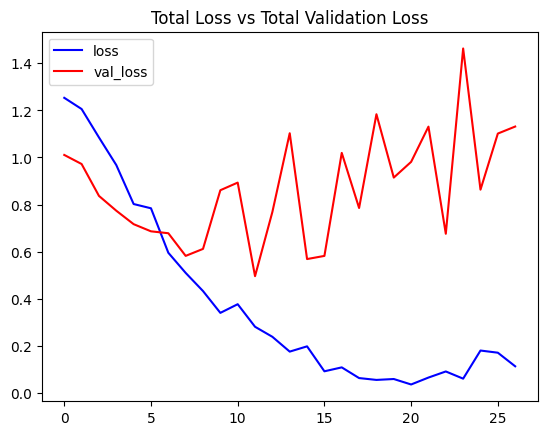

In [34]:
#visualize the training and validation loss metrices.
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

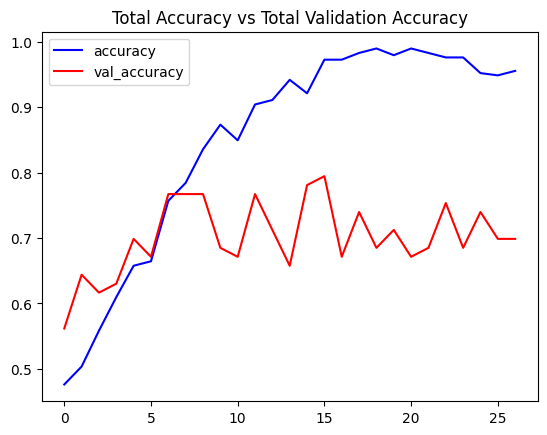

In [35]:
#Visualize the traing and validation accuracy metrices.
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

#Construct the model

In [39]:
#long ternm recurrent convolutional networks
def create_LRCN_model():
  '''
  This function will construct the required LRCN model.
  Returns:
    model: It is the required constructed LRCN model.
  '''

  # We will use a Sequential model for model construction.
  model = Sequential()

  # Define the Model Architecture.
  ########################################################################################################################

  model.add(TimeDistributed(Conv2D(16,(3,3), padding='same', activation='relu'),
                            input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

  model.add(TimeDistributed(MaxPooling2D((4,4))))
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Conv2D(32,(3,3), padding='same', activation='relu')))
  model.add(TimeDistributed(MaxPooling2D((4,4))))
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Conv2D(64,(3,3), padding='same', activation='relu')))
  model.add(TimeDistributed(MaxPooling2D((2,2))))
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Conv2D(64,(3,3), padding='same', activation='relu')))
  model.add(TimeDistributed(MaxPooling2D((2,2))))
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Flatten()))

  model.add(LSTM(32))

  model.add(Dense(len(CLASSES_LIST), activation='softmax'))

  ########################################################################################################################

  #Display the models summary.
  model.summary()

  return model

In [40]:
#construct the required LRCN model.
LRCN_model = create_LRCN_model()

#Display the success message.
print("Model Created Successfully!")


  super().__init__(**kwargs)



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_3              │ (None, 20, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 20, 16, 16, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 20, 16, 16, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 20, 16, 16, 32) │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 20, 4, 4, 32)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 20, 4, 4, 32)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 20, 4, 4, 64)   │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_10             │ (None, 20, 2, 2, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_11             │ (None, 20, 2, 2, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_12             │ (None, 20, 2, 2, 64)   │        36,928 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_13             │ (None, 20, 1, 1, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_14             │ (None, 20, 1, 1, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_15             │ (None, 20, 64)         │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,060 (285.39 KB)

 Trainable params: 73,060 (285.39 KB)

 Non-trainable params: 0 (0.00 B)

Model Created Successfully!


#Check Model's Structure:


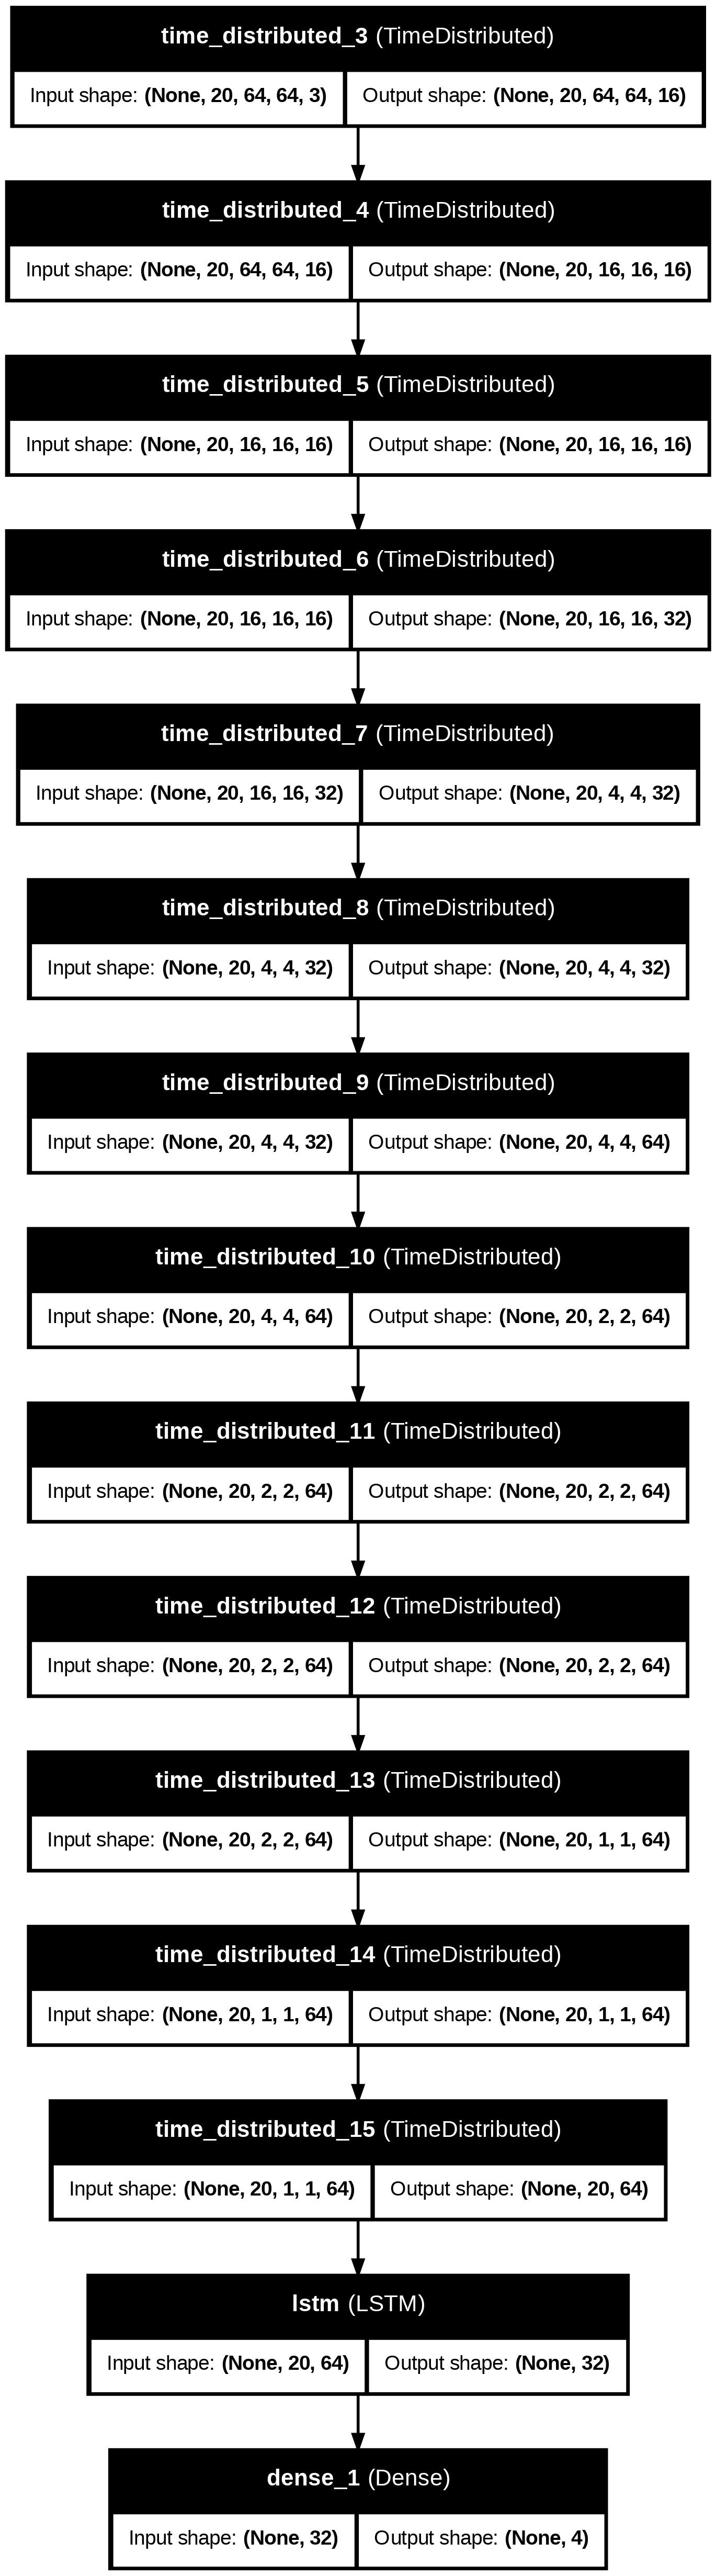

In [41]:
#Plot the structure of the constructed LRCN model.
plot_model(LRCN_model, to_file = 'LRCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)


#Compile & Train the Model

In [42]:
#Create an Instance of Early stopping callback.
early_stopping_callback =EarlyStopping(monitor='val_loss', patience=15, mode='min', restore_best_weights=True)

#Compile the model and specify loss function, optimizer and metrics to the model.
LRCN_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=["accuracy"])

#Start training the model.
LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 50, batch_size =4, shuffle=True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 75s 718ms/step - accuracy: 0.2614 - loss: 1.4151 - val_accuracy: 0.3562 - val_loss: 1.3525
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 72s 568ms/step - accuracy: 0.3119 - loss: 1.3643 - val_accuracy: 0.4658 - val_loss: 1.2194
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 77s 521ms/step - accuracy: 0.4667 - loss: 1.3315 - val_accuracy: 0.4795 - val_loss: 1.2175
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 43s 584ms/step - accuracy: 0.4584 - loss: 1.1834 - val_accuracy: 0.6164 - val_loss: 0.9899
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 40s 548ms/step - accuracy: 0.4556 - loss: 1.1091 - val_accuracy: 0.6164 - val_loss: 1.0179
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 45s 601ms/step - accuracy: 0.5110 - loss: 1.0351 - val_accuracy: 0.6164 - val_loss: 0.9032
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 81s 586ms/step - accuracy: 0.6079 - loss: 0.8928 - val_accuracy: 0.7260 - val_loss: 0.7390
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 90s 700ms/step - accuracy: 0.6078 - loss: 0.8980 - val_accu

#Evaluating the trained Model

In [43]:
#Evaluate the trained model.
model_evaluation_history =LRCN_model.evaluate(features_test, labels_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 502ms/step - accuracy: 0.9278 - loss: 0.3311


#Save the Model

In [45]:
#Get the loss and accuracy from model_evaluation_history
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

#Define the string date format.
# Get the current Date and Time in a DateTime object
# Convert the Datetime object to string according to the style mentioned in date_time_format string.

date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

#define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'LRCN_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

#Save the Model.
LRCN_model.save(model_file_name)


#Plot model's loss and accuracy curves

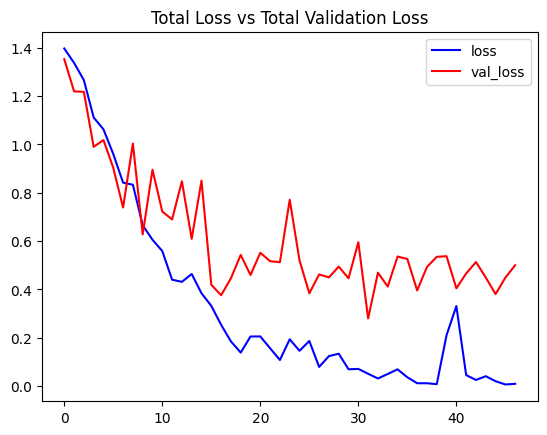

In [46]:
#visualize the training and validation loss metrices.
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

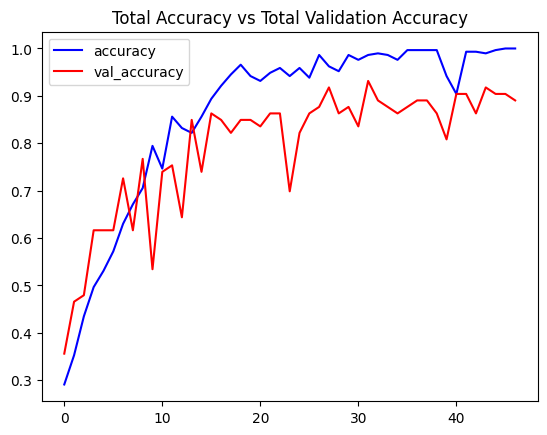

In [47]:
#visualize the traing and validation accuracy metrices.
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

#Test the best performing model on youtube videos

**Create a Function to Download youtube videos:**

In [48]:
def download_youtube_videos(youtube_video_url):
  '''
  This function will download the youtube video whose URL is passed to it as an argument.
  Args:
    youtube_video_url: URL of the video that is required to be download.
    output_directory: The directory path to which the video needs to be stored after downloading.
  Returns:
    title: The title of the downloaded youtube video.
  '''

  #Create a video object which contains useful information about the video.
  video =pafy.new(youtube_video_url)

  #Retrieve the title of the video.
  title = video.title

  #Get the best available quality object for the video.
  video_best =video.getbest()

  #construct the output file path.
  output_file_path =f'{output_directory}/{title}.mp4'

  #Download the youtube video at the best available quality and store it to the constructed path.
  video_best.download(filepath=output_file_path,quiet=True)

  return title

#Download a test video:

In [54]:
!pip install pytube

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 1.8 MB/s eta 0:00:00


In [57]:
!pip install -q --upgrade pytube


In [63]:
# Google Colab specific implementation for downloading YouTube videos
import os
import sys

# Function to install required packages
def install_required_packages():
    try:
        # Check if yt-dlp is installed
        import importlib
        try:
            importlib.import_module('yt_dlp')
            print("yt-dlp is already installed.")
        except ImportError:
            print("Installing yt-dlp...")
            # Use a Colab-specific command for installation
            !pip install -q yt-dlp
            print("yt-dlp installed successfully.")
    except Exception as e:
        print(f"Failed to install required packages: {e}")
        raise

def download_youtube_videos(url, output_directory):
    """
    Download a YouTube video using yt-dlp in Google Colab

    Args:
        url (str): YouTube video URL
        output_directory (str): Directory to save the downloaded video

    Returns:
        str: Title of the video (without extension)
    """
    try:
        # Ensure yt-dlp is installed
        install_required_packages()

        # Import after installation
        import yt_dlp

        # Options for yt-dlp
        ydl_opts = {
            'format': 'best[ext=mp4]/bestvideo[ext=mp4]+bestaudio[ext=m4a]/best',
            'outtmpl': f'{output_directory}/%(title)s.%(ext)s',
            'noplaylist': True,
            'quiet': False,
            'no_warnings': False
        }

        # Get info first to extract title
        with yt_dlp.YoutubeDL(ydl_opts) as ydl:
            info = ydl.extract_info(url, download=False)
            video_title = info.get('title', None)
            safe_title = "".join([c for c in video_title if c.isalpha() or c.isdigit() or c==' ']).rstrip()
            safe_title = safe_title.replace(' ', '_')

            print(f"Downloading: {video_title}")

            # Now download the video
            ydl_opts['outtmpl'] = f'{output_directory}/{safe_title}.%(ext)s'
            with yt_dlp.YoutubeDL(ydl_opts) as ydl:
                ydl.download([url])

            print(f"Download complete: {safe_title}.mp4")
            return safe_title

    except Exception as e:
        print(f"An error occurred: {e}")
        print("This could be due to YouTube's security measures or network issues.")
        print("Try a different video URL or check your Colab runtime's internet connection.")
        raise

# Example usage in Google Colab
# Make the output directory if it does not exist
test_video_directory = 'test_videos'
os.makedirs(test_video_directory, exist_ok=True)

# Sample code for Colab to download a video
# Just run this cell
try:
    video_url = 'https://www.youtube.com/watch?v=8u0qjmHIOcE'  # Your original URL
    video_title = download_youtube_videos(video_url, test_video_directory)

    print(f"Video saved as: {test_video_directory}/{video_title}.mp4")

    # Get the youtube videos path for further processing
    input_video_file_path = f'{test_video_directory}/{video_title}.mp4'
    print(f"Video path: {input_video_file_path}")

    # Verify the file exists
    if os.path.exists(input_video_file_path):
        print(f"File size: {os.path.getsize(input_video_file_path) / (1024*1024):.2f} MB")

        # Display the video in Colab if needed
        from IPython.display import HTML
        from base64 import b64encode

        # Uncomment the below code to display the video in the notebook
        # mp4 = open(input_video_file_path, 'rb').read()
        # data_url = f"data:video/mp4;base64,{b64encode(mp4).decode()}"
        # HTML(f"""
        # <video width=400 controls>
        #     <source src="{data_url}" type="video/mp4">
        # </video>
        # """)
except Exception as e:
    print(f"Failed to download video: {e}")

Installing yt-dlp...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.3/173.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 37.4 MB/s eta 0:00:00
yt-dlp installed successfully.
[youtube] Extracting URL: https://www.youtube.com/watch?v=8u0qjmHIOcE
[youtube] 8u0qjmHIOcE: Downloading webpage
[youtube] 8u0qjmHIOcE: Downloading tv client config
[youtube] 8u0qjmHIOcE: Downloading player 804c67d2-main
[youtube] 8u0qjmHIOcE: Downloading tv player API JSON
[youtube] 8u0qjmHIOcE: Downloading ios player API JSON
[youtube] 8u0qjmHIOcE: Downloading m3u8 information
Downloading: Test Video
[youtube] Extracting URL: https://www.youtube.com/watch?v=8u0qjmHIOcE
[youtube] 8u0qjmHIOcE: Downloading webpage
[youtube] 8u0qjmHIOcE: Downloading tv client config
[youtube] 8u0qjmHIOcE: Downloading player 1b376dba-main
[youtube] 8u0qjmHIOcE: Downloading tv player API JSON
[youtube] 8u0qjmHIOcE: Downloading ios player API JSON
[youtube] 8u0qjmHIOcE: Downloading m3u8 information
[i

In [64]:
# Display the downloaded video in Colab
from IPython.display import HTML
from base64 import b64encode
import os

# Define the path to your video
video_path = 'test_videos/Test_Video.mp4'

# Check if the file exists
if os.path.exists(video_path):
    # Read the file and encode it to base64
    mp4 = open(video_path, 'rb').read()
    data_url = f"data:video/mp4;base64,{b64encode(mp4).decode()}"

    # Display the video with controls
    display(HTML(f"""
    <video width=600 controls>
        <source src="{data_url}" type="video/mp4">
        Your browser does not support the video tag.
    </video>
    """))
    print("Video displayed above. If you don't see it, check that the video file exists and is a valid MP4.")
else:
    print(f"Error: Video file not found at {video_path}")

Video displayed above. If you don't see it, check that the video file exists and is a valid MP4.


In [58]:
from pytube import YouTube
import os

def download_youtube_videos(youtube_url, save_path):  # ← TWO parameters here
    yt = YouTube(youtube_url)
    stream = yt.streams.filter(progressive=True, file_extension='mp4').get_highest_resolution()

    # Clean the title to use as filename
    title = yt.title
    safe_title = ''.join(c for c in title if c.isalnum() or c in ' _-').rstrip()
    file_name = safe_title + ".mp4"

    # Download the video
    stream.download(output_path=save_path, filename=file_name)

    return file_name  # Return full filename including .mp4


In [61]:
#Make the output directory if it does not exist
test_video_directory = 'test_videos'
os.makedirs(test_video_directory, exist_ok = True)

#Download a test video.
video_title = download_youtube_videos('https://www.youtube.com/watch?v=8u0qjmHIOcE', test_video_directory)

#Get the youtube videos path we just downloaded
input_video_file_path = f'{test_video_directory}/{video_title}.mp4'

HTTPError: HTTP Error 400: Bad Request

#create a function to perform Action recognition on videos

In [ ]:
def predict_on_video(video_file_path, required_model):
  '''
  This function will perform action recognition on a video using the required model.
  Args:
    video_file_path:  The path of the video whose action is recogniiton is to be performed.
    output_file_path: The path of the video in which predicted action labels are to be overlayed.
    SEQUENCE_LENGTH:  The fixed number of frames of a video that can be passed to the model as one sequence.
  '''

  #Initialize the videoCapture object to read form the video file
  video_reader = cv2.VideoCapture(video_file_path)

  #Get the width and height of the video.
  original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
  original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

  #Initialize the videoWriter object to store the output video in the disk.
  video_writer=cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'),
                                video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))

  #Declare a queue to store video frames.
  frames_queue = deque(maxlen = SEQUENCE_LENGTH)

  #Initialize a variable to store the predicted action being performed in the vide.
  predicted_class_name =''

  #Iterate until the video is accessed successfully.
  while video_reader.isOpened():

    #Read the frame.
    ok, frame = video_reader.read()

    #Check if frame is not read properly then break the loop.
    if not ok:
      break

    #Resize the frame to fixed dimensions.
    resized_frame =cv2.resizeWindow

    #Appending the pre-processed frame into the frames list.
    frames_queue.append(normalized_frame)

    #Check if the number of frames in the queue are equal to the fixed sequence length.
    if len(frames_queue) == SEQUENCE_LENGTH:

      #Pass the normalized frames to the model and get the predicted probabilities.
      predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_queue, axis =0))[0]

      #Get the index of class with highest probability.
      predicted_label = np.argmax(predicted_labels_probabilities)

      #Get the class name using the retrieved index.
      predicted_class_name = CLASSES_LIST[predicted_label]

    #write predicted class name on top of the frame.
    cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)


    #write the frame into the disk using the VideoWriter Object.
    video_writer.write(frame)

  #Release the VideoCapture and VideoWriter objects.
  video_reader.release()
  video_writer.release()

#Perform Action Recognition on the test video

In [ ]:
#Construct the output video path.
output_video_file_path =f'{test_videos_directory}/{video_title}-Output-SeqLen{SEQUENCE_LENGTH}.mp4'

#Perform Action Recognition on the test video.
predict_on_video(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)

#Display a the output video.
VideoFileClip(output_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()